In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
from bs4 import BeautifulSoup
import re
####한국어 형태소 분석기####
from konlpy.tag import Kkma, Komoran, Okt, Hannanum, Mecab
okt = Okt()
kkma = Kkma()
komoran = Komoran()
hannanum = Hannanum()
mecab = Mecab()
import unicodedata
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import random
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

In [2]:
#Random seed 고정
def random_seed(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os

In [3]:
random_seed(42)

In [4]:
os.getcwd()

'/Users/sera/company/ReportCrawling'

In [5]:
data = pd.read_csv('reportdata.csv')
data.content = list(map(lambda x : ''.join(eval(x)), data.content))
data.filename = list(map(lambda x: unicodedata.normalize('NFC',x), data.filename))

# 한투 & 시총 100위 리포트 

# Text cleansing

### 기본 html tag, \n 제거

In [6]:
data.content = data.content.replace('<.*?>|{\s?.*\s?}|\n'," ",regex=True)

###  "font~" ,"#f숫자" 제거

In [7]:
data.content = data.content.replace("#f[\d]+|@font[\D]+","",regex=True)

### 2칸 이상의 공백 제거

In [8]:
data.content = data.content.replace("\s+"," ",regex=True)

### 돈 단위 (억원, 만원..) 삭제

확률은 적지만 full 이라는 의미의 "만원"이 삭제될 우려가 있어서 정규표현식사용

In [9]:
data.content = data.content.replace('[\w]+\s?만원|[\w]+\s?억원|[\w]+\s?조원',"",regex=True)

### 숫자제거

In [10]:
data.content = data.content.replace('\d+',' ',regex=True)
data.content = data.content.replace("\s+"," ",regex=True)

### 이메일제거

In [11]:
data.content = data.content.replace('[\w\-\.]+\@[\w\-\.]+', " ",regex=True)

### 특수문자 제거

In [12]:
data.content = data.content.replace("[\(\)-=+,#/\/\?:^%$@*※~&ㆍ!』\\|\[\]\<\>…》│〓'［【】\[\]▽▼△▲▲■◇♦◆○●ⓒΔ▷▶�━ㆍ㈜]", " ",regex=True)

### Compliance notice 이후 부분 모두 삭제

In [13]:
data.content = data.content.replace('(?=(Compliance notice)).+',"",regex=True)
data.content = data.content.replace("\s+"," ",regex=True)

### txt 기업 C omment, txt 실적 Review, txt 기업 Note, txt 기업 Brief

In [14]:
data.content = data.content.replace(' txt 기업 C omment','',regex=True)
data.content = data.content.replace(' txt 실적 Review','',regex=True)
data.content = data.content.replace(' txt 기업 Note','',regex=True)
data.content = data.content.replace(' txt 기업 Brief','',regex=True)

### 투자의견 및 목표주가 ~ 이후 삭제

In [15]:
data.content = data.content.replace('(?<=)(투자의견 및 목표주가).+','',regex=True)

### 불용어사전 (1차)

In [16]:
stopwords = ['YoY', 'QoQ','개월','page','목표주가','매출액','영업이익','순이익',
             'EPS', '증감률', 'EBITDA', 'PER', 'EV', 'EBITDA', 'PBR', 'ROE', 'DY','지배주주지분',
            '최고','최저가','주가상승률','하 회 부 합','시가총액','발행주식수','일평균거래대금',
            '유동주식비율','외국인지분율','주요주주','FnGuide',
            'Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Oct','Nov','Dec',
            'page','txt','절대주가']

In [17]:
#mecab사용 + noun 만 + 단어길이 2이상만 추출
def remove_stopwords(content):
    nouns = mecab.nouns(content)
    #불용어제거, 단어길이 2이상
    words = []
    for w in nouns :
        if w not in stopwords and len(w)>=2:
            words.append(w)
    return words


In [18]:
clean_nouns = []
for doc in tqdm(data.content) :
    clean_nouns.append(remove_stopwords(doc))

100%|████████████████████████████████████████| 982/982 [00:01<00:00, 491.61it/s]


In [19]:
report_cleannouns = pd.concat([data.filename,pd.DataFrame([clean_nouns]).T],axis=1)

In [20]:
report_cleannouns.columns = ['filename','nouns']

In [21]:
report_cleannouns.to_csv('repot_cleannouns.csv',index=False)

In [22]:
report_cleannouns

,filename,nouns
0,한투20170224SKT,"[텔레콤, 매수, 유지, 플래닛, 투자, 유치, 무산, 영향, 미미, 표주, 유지,..."
1,한투20170124SK,"[매수, 유지, 실트론, 인수, 긍정, 표주, 유지, 주가, 발행주, 식수, 백만,..."
2,한투20190425KB금융,"[금융, 센서스, 대비, 의미, 생각, 정상, 센서스, 부합, 증권, 포함, 전반,..."
3,한투20170710엔씨소프트,"[소프트, 매수, 유지, 하향, 안정, 고민, 시기, 표주, 유지, 주가, 발행주,..."
4,한투20190201LG전자,"[전자, 영업, 이익, 센서스, 대비, 의미, 춥다, 월초, 잠정, 실적, 유사, ..."
...,...,...
977,한투20170323KT,"[매수, 유지, 수익, 호전, 배당, 증가, 예상, 표주, 유지, 주가, 발행주, ..."
978,한투20170828한국전력,"[한국전력, 매수, 유지, 원전, 가동, 바닥, 분기, 회복, 전망, 표주, 유지,..."
979,한투20180703CJ제일제당,"[제일제당, 헬스, 케어, 매각, 선방, 매수, 유지, 표주, 유지, 영업, 이익,..."
980,한투20190128현대글로비스,"[현대, 비스, 영업, 이익, 센서스, 대비, 의미, 그림, 시점, 매수, 유지, ..."


### 불용어사전 (2차) : 전체 문서에서의 상위 빈출단어를 살핀 후 제거

In [23]:
noun_list_mecab = list(np.concatenate(np.array(clean_nouns)))

/var/folders/xb/2s8ljjjd6zg0df496bld_5bw0000gn/T/ipykernel_49425/3781243966.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  noun_list_mecab = list(np.concatenate(np.array(clean_nouns)))


In [24]:
from collections import Counter
vocab_freq= Counter(noun_list_mecab).most_common() #갯수 많은 순으로 리스트 반환, 리스트 원소는 튜플형태

In [25]:
#전체단어별 index 부여 - 높은 빈도가 인덱스 1로 시작
word_to_index = {}
i=0
for (word, frequency) in vocab_freq :
    i = i + 1
    word_to_index[word] = i

In [26]:
vocab = list(word_to_index.keys())

In [27]:
len(vocab)

7110

In [28]:
print(vocab)

['이익', '주가', '분기', '영업', '증가', '대비', '실적', '유지', '상승', '전망', '매출', '지분', '예상', '사업', '투자', '센서스', '주주', '추정', '전년', '자료', '수익', '매수', '개선', '성장', '표주', '주요', '감소', '기준', '유동', '평균', '시장', '비용', '비율', '추이', '백만', '거래', '주식', '하락', '부문', '자산', '부진', '가격', '최저', '대금', '외국인', '식수', '한국', '발행주', '현대', '중국', '수준', '지속', '배당', '가능', '반영', '때문', '확대', '지배', '동기', '달러', '증권', '국민', '연금', '판매', '국내', '기록', '하반기', '수요', '의견', '기타', '올해', '해외', '지표', '하회', '상회', '영향', '수주', '가치', '기대', '목표', '회복', '출시', '기존', '단위', '효과', '업체', '관련', '삼성', '제품', '그림', '현금', '하향', '면세점', '증감', '비중', '생산', '안정', '상대', '연결', '이후', '바이오', '조정', '손익', '우리', '이상', '부담', '금융', '삼성전자', '추가', '서비스', '적용', '상향', '중공업', '미국', '규모', '적자', '부합', '우려', '신규', '판단', '요인', '구조', '기업', '부채', '글로벌', '계획', '장기', '향후', '자본', '의미', '감안', '가입자', '패널', '긍정', '전환', '흐름', '가동', '최근', '연간', '손실', '공장', '시작', '호조', '화장품', '발생', '마진', '경쟁', '설비', '제외', '공급', '디램', '리니지', '축소', '재고', '단기', '상황', '통신', '세전', '평가', '자동차', '점유', '모바일', '상반기', '경우'

In [29]:
stopwords2 = ['이익', '주가', '분기', '영업', '증가', '대비', '실적', '유지', '상승', '전망', '매출', 
              '지분', '예상', '사업', '투자', '센서스', '주주', '추정', '전년', '자료', '수익', '매수',
              '개선', '성장', '표주', '주요', '감소', '기준', '유동', '평균', '시장', '비율', '비용', '추이', 
              '백만', '거래', '주식', '하락', '부문', '자산', '부진', '가격', '최저', '대금', '외국인', '식수',
              '한국', '발행주', '현대', '중국', '수준', '지속', '배당', '가능', '반영', '때문', '확대', '지배', 
              '동기', '달러', '증권', '국민', '연금', '판매', '국내', '기록', '하반기', '수요', '의견', '기타', 
              '올해', '해외', '지표', '하회', '상회', '영향', '수주', '가치', '기대', '목표', '회복', '출시', '기존',
              '단위', '효과', '업체', '관련', '제품', '그림', '현금', '하향', '면세점', '증감', '비중', '생산',
              '안정', '상대', '연결', '이후', '조정', '손익', '우리', '이상', '부담',  '추가',
              '서비스', '적용', '상향', '규모', '부합', '판단', '요인', '구조', 
              '기업', '계획', '장기', '향후', '자본', '의미', '감안', '패널', '긍정',  
              '흐름', '연간', '최근', '시작', '발생', '경쟁', '제외', 
              '축소',  '단기', '상황',  '세전', '평가', '점유',
              '경우', '변경', '예정', '회사', '고려','지주','보유', 
              '매각', '원가', '차입금', '진행', '강화', '차이', '작년', '인상', 
              '당사', '필요', '중립', '산업', '가정', '한편',
              '시점', '내년', '정책', '계약', '확보', '둔화', '총계', '환경', '유형', 
              '발표', '순증', '본격', '고객', '성향', '포함', '전체', 
              '낸드', '에서', '반면',  
              '하나', '재무', '전략', '이자', '기여', 
              '결정', '해소', '활동', '달성', '정상', '매력', '충당', 
              '판매량', '할인', '결론', '소재', '시기', '유사', '주목', '기저', '일부', '으로', 
              '당초', '당기', '완화', '이번', '이동',
              '순차', '이유', '포괄', '만큼', '소폭',
              '기반', '도입', '부각', '관리', '핵심', '추세', 
              '대손', '가운데', '제시', '개편', '효율', '입금', '주당', '지급', 
              '시황', '현재', '스프']

In [30]:
stopwords.extend(stopwords2)

In [31]:
len(stopwords)

267

# 종목 뽑아내기

In [32]:
data.filename

0         한투20170224SKT
1          한투20170124SK
2        한투20190425KB금융
3       한투20170710엔씨소프트
4        한투20190201LG전자
             ...       
977        한투20170323KT
978      한투20170828한국전력
979    한투20180703CJ제일제당
980    한투20190128현대글로비스
981    한투20190510롯데하이마트
Name: filename, Length: 982, dtype: object

In [33]:
stock = [str(x[10:]) for x in data.filename]

In [34]:
# 놀랍게도 mac os 의 문제인지 '삼성' in 삼성중공업' false 가 났는데... 자모음이 분리 된채였기 때문
import unicodedata
stock = list(map(lambda x: unicodedata.normalize('NFC',x), stock))

In [35]:
stock = list(set(stock))

In [36]:
print(stock)

['우리금융지주', '엔씨소프트', '현대글로비스', 'KT2', 'DB손해보험', '현대제철', '강원랜드', '현대건설', 'LGU', 'LG하우시스', '삼성전기', 'GS건설', 'LG유플러스', '현대모비스', '하나금융지주', '삼성SDI', 'SK', '현대건설기계', '두산중공업', '팬오션', 'KB금융', '금호석유', 'SK이노베이션', 'LG유플러스2', '삼성화재', '셀트리온헬스케어', '삼성카드', '삼성엔지니어링', '현대차', '코웨이', 'LGD', '대한항공', 'SK텔레콤2', 'SK하이닉스', '삼성생명', '유한양행', '기아차', 'SK머티리얼즈', '롯데케미칼', '삼성전자', 'GS홈쇼핑', '메리츠화재', '아모레퍼시픽', 'LG디스플레이', 'KTH', 'KTG', '현대중공업지주', '넷마블', '한국항공우주', 'LG화학', '1삼성카드', 'SK텔레콤', '기업은행', '넷마블게임즈', '삼성바이오로직스', 'SKT', '오리온', '삼성중공업', '고려아연', '한국전력', 'NAVER', '호텔신라', '삼성물산', '한국가스공사', '롯데하이마트', 'LG생활건강', 'SKT2', '아모레퍼시픽2', '셀트리온', 'NH투자증권', 'SKC코오롱PI', '두산밥캣', '카카오', 'GS', 'KT', 'LG이노텍', 'CJ제일제당', '한국타이어앤테크놀로지', '현대중공업', 'GS리테일', 'CJ제일제당2', 'LG전자', '신한지주', 'SK디앤디', '삼성증권', '이마트', 'S-Oil', '롯데지주NR', '아모레G', '한온시스템', '한미약품', '롯데지주', 'LG생건']


In [37]:
len(stock)

93

# Modeling

In [38]:
def construct_X(vocab,data):
    X = np.zeros(shape=(len(vocab),len(data))) #단어수 , 문서수 
    for j in range(len(data)):
        #document 별 단어수 카운트
        cnt_per_doc = data[j]
        for key, val in cnt_per_doc.items():
            #j 번째 열(문서)에 i 행의 값(단어수)을 추가
            X[key-1,j] = val # 단어 index가 1부터 시작하기 때문
    X = csr_matrix(X)
    return X

def NMF(n_iters, n_topics, X, W, H, random_state = 42):
    
    k = n_topics
    m,n = X.shape
    errors = []
    it = 0
    WH = W@H 
    
    for it in tqdm(range(n_iters)):
        random_seed(random_state)
        #UPDATE RULE
        
        #update H====================================
        
        #normalize rows of W
        #W = W/np.sum(W,axis=1).reshape(-1,1)
        
        #분자분모계산
        num_h = np.array(W.T @ (X/(WH+1e-16)))
        denom_h = np.sum(W,axis=0).reshape(k,1)
        
        H = H * (num_h /(denom_h+1e-16))
    
        #update W====================================
        WH = W@H
        
        
        #분자분모계산
        num_w =  np.array((X/(WH+1e-16)) @ H.T)
        denom_w = np.sum(H, axis=1)
        
        W = W * (num_w /(denom_w+1e-16))
        
        #CALCULATE ERROR
        WH = W@H
        errors.append(-np.sum(X.multiply(np.log(W@H+1e-16)) - WH))
        
    
    return H, W, errors

def top10_per_topic(W_norm):
    top10 = pd.DataFrame()
    #몇번째 토픽에서 10개의 상위 단어를 보여줄지
    for k in range(W_norm.shape[1]):

        #상위 10개 인덱스 저장
        idx = np.argsort(W_norm[:,k])[::-1][:10]

        #10개 단어, 각 weight
        words = list(map(lambda i : vocab[i], idx))
        weights = W_norm[:,k][idx]

        #dataframe으로 결과반환
        tmp = pd.DataFrame(zip(words,weights))
        tmp.columns = ['topics_{}'.format(k+1),'weight_{}'.format(k+1)]
        top10 = pd.concat([top10,tmp],axis=1)
        

    return top10
    
def coherence(topics,corpus,dictionary):
    cm = CoherenceModel(topics=topics, 
                        corpus=corpus,
                        dictionary = dictionary,
                        coherence="u_mass")
    coherence = cm.get_coherence()
    #perplexity = self.model.log_perplexity(corpus)
    return coherence


#### 약 배타적인 섹터의 종목 15개씩 한 문서세트로 구성 
#### 문서 세트 6개에 대해 6번 분석 결과를 살핀뒤 모델의 품질이 유지되는지 확인

`set1` =  ['현대모비스', 'KT', '엔씨소프트','롯데하이마트','S-Oil',   
        '셀트리온','한국항공우주','KB금융','LG전자','삼성생명',  
        '메리츠화재', '강원랜드','아모레퍼시픽', 'SK디앤디','NAVER']  
        
`set2` = ['현대건설', '넷마블','LG유플러스', '고려아연','SK이노베이션',  
        'GS홈쇼핑','오리온','NH투자증권', '한미약품','신한지주',  
        '대한항공','한국타이어앤테크놀로지', '코웨이','DB손해보험', '호텔신라']  

`set3` = ['롯데케미칼','LGD','셀트리온헬스케어', '유한양행','기아차',  
        'SKT','삼성화재','CJ제일제당','아모레G','넷마블게임즈',  
        '기업은행','이마트','GS','한국전력','팬오션']  

`set4` = ['LG하우시스',삼성전자', '한온시스템', '현대중공업지주', 'GS건설',  
        '롯데지주', 'KTH','삼성SDI','SKC코오롱PI','한국가스공사',  
        '금호석유','우리금융지주','SK하이닉스','카카오','KTG']  
         
* 모회사가 (삼성, 현대, lg) 가 많이 중복적으로 포함된 경우  
`set5` = ['LG이노텍', '삼성증권','현대건설기계', '두산밥캣', 'SK',  
        '롯데지주NR', '하나금융지주', '삼성카드', 'LG화학', '현대차',  
        '현대중공업',SK머티리얼즈','LG생활건강','삼성물산', '삼성바이오로직스']  

* 그 외에도 일반적인 경우 (섹터 중복이 많은 경우)  
`set6` = ['삼성전기', '롯데지주NR','두산중공업', '현대제철', '현대글로비스',   
        '삼성중공업','삼성엔지니어링']

# hypyerparameter

In [44]:
iters=100

# `Set1` 

### = ['현대모비스', 'KT', '엔씨소프트','롯데하이마트','S-Oil',  '셀트리온','한국항공우주','KB금융','LG전자','삼성생명',  '메리츠화재', '강원랜드','아모레퍼시픽', 'SK디앤디','NAVER']

In [39]:
for x in stock:
    if '현대' in x :
        print(x)

현대글로비스
현대제철
현대건설
현대모비스
현대건설기계
현대차
현대중공업지주
현대중공업


In [40]:
for x in stock:
    if 'KT' in x or '케이' in x :
        print(x)

KT2
KTH
KTG
SKT
SKT2
KT


In [41]:
set1 = pd.DataFrame()
set1_doc_cnt = pd.DataFrame()
names = ['현대모비스','KT','KT2','엔씨소프트','롯데하이마트','S-Oil',
        '셀트리온','한국항공우주','KB금융','LG전자','삼성생명','메리츠화재','강원랜드',
        '아모레퍼시픽','아모레퍼시픽2','SK디앤디']
for name in names : 
    set1 = pd.concat([set1, data[[name == x[10:] for x in data.filename]]])
    set1_doc_cnt = pd.concat([set1_doc_cnt,pd.DataFrame(zip([name], [sum([name == x[10:] for x in data.filename])]))])

In [42]:
set1_doc_cnt

,0,1
0,현대모비스,14
0,KT,30
0,KT2,6
0,엔씨소프트,28
0,롯데하이마트,10
0,S-Oil,8
0,셀트리온,1
0,한국항공우주,11
0,KB금융,10
0,LG전자,12


/var/folders/xb/2s8ljjjd6zg0df496bld_5bw0000gn/T/ipykernel_49425/3451173828.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  noun_list_mecab = list(np.concatenate(np.array(clean_nouns)))
100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 45.97it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

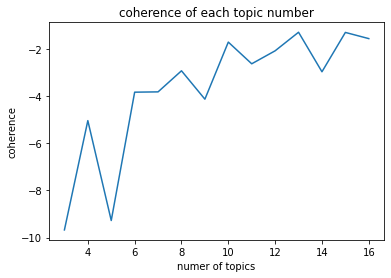

In [45]:
clean_nouns = []
for doc in set1.content:
    clean_nouns.append(remove_stopwords(doc))
noun_list_mecab = list(np.concatenate(np.array(clean_nouns)))
from collections import Counter
vocab_freq= Counter(noun_list_mecab).most_common() #갯수 많은 순으로 리스트 반환, 리스트 원소는 튜플형태
#전체단어별 index 부여 - 높은 빈도가 인덱스 1로 시작
word_to_index = {}
i=0
for (word, frequency) in vocab_freq :
    i = i + 1
    word_to_index[word] = i
vocab = list(word_to_index.keys())
vocab_freq_per_doc = []
for doc in clean_nouns:
    tmp = {}
    vocab_freq= Counter(doc).most_common() #갯수 많은 순으로 리스트 반환, 리스트 원소는 튜플형태
    for idx in range(len(vocab_freq)):
        key = word_to_index[vocab_freq[idx][0]]
        val = vocab_freq[idx][1]
        
        tmp[key]=val
    vocab_freq_per_doc.append(tmp)
dictionary = corpora.Dictionary(clean_nouns)
corpus = [dictionary.doc2bow(text) for text in clean_nouns]
X = construct_X(vocab, vocab_freq_per_doc)
n_topics = [3,4,5,6,7,8,9,10,11,12,13,14,15,16]
coherence_list = []
H_res = []
W_res = []
errors_res = []
for rank in n_topics:
    # Randomly initialize W, H with nonnegative values : uniform (1,2)
    W = np.random.uniform(1,2,(X.shape[0], rank))
    H = np.random.uniform(1,2,(rank,X.shape[1]))
    H, W, errors = NMF(iters, rank, X, W, H)
    H_res.append(H)
    W_res.append(W)
    errors_res.append(errors)
    topics = top10_per_topic(W).iloc[:,list(range(0,rank*2,2))].T.values.tolist()
    coherence_list.append(coherence(topics, corpus, dictionary))
plt.plot(n_topics, coherence_list)
plt.ylabel('coherence')
plt.xlabel('numer of topics')
plt.title('coherence of each topic number')
plt.show

확실히 메리츠, 셀트리온 문서수가 1개밖에 없다보니 13에서 coherence 지표가 높게 나온 모습!!

In [46]:
n_topics[-2]

15

In [47]:
set1_result = top10_per_topic(W_res[-2]).iloc[:,list(range(0,15*2,2))]

In [48]:
set1_doc_cnt

,0,1
0,현대모비스,14
0,KT,30
0,KT2,6
0,엔씨소프트,28
0,롯데하이마트,10
0,S-Oil,8
0,셀트리온,1
0,한국항공우주,11
0,KB금융,10
0,LG전자,12


In [49]:
set1_result.columns=['LG전자','현대모비스','한국항공우주','?','엔씨소프트',
    '현대모비스','KT','KB금융','SK디앤디','엔씨소프트',
    '강원랜드','롯데하이마트','삼성생명','아모레퍼시픽','S-oil'
]

In [50]:
X.shape

(2866, 179)

In [51]:
set1_result

,LG전자,현대모비스,한국항공우주,?,엔씨소프트,현대모비스,KT,KB금융,SK디앤디,엔씨소프트,강원랜드,롯데하이마트,삼성생명,아모레퍼시픽,S-oil
0,전자,전자,수출,수출,리니지,모듈,가입자,은행,앤디,리니지,카지노,롯데,삼성생명,화장품,마진
1,가전,이노,항공우주,인식,게임,부품,부동산,대출,개발,소프트,강원랜드,이마트,삼성,아모레,정제
2,휴대폰,의류,재개,항공우주,이용자,현대모비스,인터넷,금융,리츠,모바일,테이블,온라인,생명,퍼시픽,유가
3,적자,건조기,공시,완제,모바일,모비스,통신,그룹,프로젝트,게임,드롭,채널,금리,브랜드,설비
4,스마트폰,자동차,우려,수리온,소프트,물류,요금,경상,부동산,신작,총량,가전,삼성전자,내수,보수
5,잠정,개발,문제,요금제,아이템,기아,호전,자회사,오피스,흥행,방문객,상품,보험,설화,재고
6,프리미엄,솔루션,헬기,양산,거래소,자동차,초고속,캐피탈,방향,이용자,기부금,마진,계열사,글로벌,가동
7,에너지,부품,수리온,프로젝트,기능,호조,규제,금리,디벨로,블레이드,올림픽,건조기,마진,용품,배럴
8,세부,주행,잔고,일회성,콘텐츠,사드,단말기,수수료,공시,업데이트,공단,오프라인,손해,생활,악재
9,전장,차량,부품,공시,레볼루션,김진우,마케팅,보험,호텔,레볼루션,가동,쇼핑,보험료,관광객,정기


SK 디앤디 : 
    부동산개발사업(개발기획 및 실행, 마케팅, 운용)과 신재생에너지개발사업

나오지 않은 것  
- '셀트리온',
- '메리츠화재',


왜 이렇게 `엔씨소프트, 현대모비스` 이 많이 나왔지?/`셀트리온`,`메리츠화재`

<예상원인>  
- 문서수의 편차때문?
- 아니면 15개의 토픽은 너무 많은 느낌인건가?

#### 종목별 문서수 확인

In [52]:
set1_doc_cnt

,0,1
0,현대모비스,14
0,KT,30
0,KT2,6
0,엔씨소프트,28
0,롯데하이마트,10
0,S-Oil,8
0,셀트리온,1
0,한국항공우주,11
0,KB금융,10
0,LG전자,12


# `Set2` 

### = ['현대건설', '넷마블','LG유플러스', '고려아연','SK이노베이션',  'GS홈쇼핑','오리온','NH투자증권', '한미약품','신한지주',  '대한항공','한국타이어앤테크놀로지', '코웨이','DB손해보험', '호텔신라']  


In [53]:
for x in stock:
    if '신라' in x :
        print(x)

호텔신라


In [54]:
set2 = pd.DataFrame()
set2_doc_cnt = pd.DataFrame()
names = ['현대건설','넷마블','넷마블게임즈','LGU','LG유플러스','LG유플러스2','고려아연',
        'SK이노베이션','GS홈쇼핑','오리온','NH투자증권','한미약품','신한지주',
        '대한항공','한국타이어앤테크놀로지','코웨이','DB손해보험','호텔신라']
for name in names : 
    set2 = pd.concat([set2, data[[name == x[10:] for x in data.filename]]])
    set2_doc_cnt = pd.concat([set2_doc_cnt,pd.DataFrame(zip([name], [sum([name == x[10:] for x in data.filename])]))])

/var/folders/xb/2s8ljjjd6zg0df496bld_5bw0000gn/T/ipykernel_49425/1786534454.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  noun_list_mecab = list(np.concatenate(np.array(clean_nouns)))
100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 44.84it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

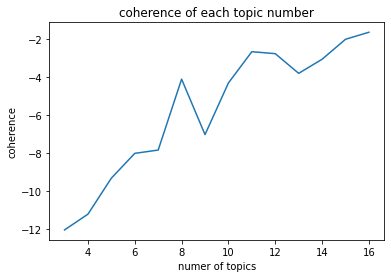

In [55]:
clean_nouns = []
for doc in set2.content:
    clean_nouns.append(remove_stopwords(doc))
noun_list_mecab = list(np.concatenate(np.array(clean_nouns)))
from collections import Counter
vocab_freq= Counter(noun_list_mecab).most_common() #갯수 많은 순으로 리스트 반환, 리스트 원소는 튜플형태
#전체단어별 index 부여 - 높은 빈도가 인덱스 1로 시작
word_to_index = {}
i=0
for (word, frequency) in vocab_freq :
    i = i + 1
    word_to_index[word] = i
vocab = list(word_to_index.keys())
vocab_freq_per_doc = []
for doc in clean_nouns:
    tmp = {}
    vocab_freq= Counter(doc).most_common() #갯수 많은 순으로 리스트 반환, 리스트 원소는 튜플형태
    for idx in range(len(vocab_freq)):
        key = word_to_index[vocab_freq[idx][0]]
        val = vocab_freq[idx][1]
        
        tmp[key]=val
    vocab_freq_per_doc.append(tmp)
dictionary = corpora.Dictionary(clean_nouns)
corpus = [dictionary.doc2bow(text) for text in clean_nouns]
X = construct_X(vocab, vocab_freq_per_doc)
n_topics = [3,4,5,6,7,8,9,10,11,12,13,14,15,16]
coherence_list = []
H_res = []
W_res = []
errors_res = []
for rank in n_topics:
    # Randomly initialize W, H with nonnegative values : uniform (1,2)
    W = np.random.uniform(1,2,(X.shape[0], rank))
    H = np.random.uniform(1,2,(rank,X.shape[1]))
    H, W, errors = NMF(iters, rank, X, W, H)
    H_res.append(H)
    W_res.append(W)
    errors_res.append(errors)
    topics = top10_per_topic(W).iloc[:,list(range(0,rank*2,2))].T.values.tolist()
    coherence_list.append(coherence(topics, corpus, dictionary))
plt.plot(n_topics, coherence_list)
plt.ylabel('coherence')
plt.xlabel('numer of topics')
plt.title('coherence of each topic number')
plt.show

In [56]:
set2_result = top10_per_topic(W_res[-2]).iloc[:,list(range(0,15*2,2))]

In [57]:
set2_result.columns=['SK이노베이션','신한지주','호텔신라','현대건설','고려아연'
                     ,'오리온','대한항공','코웨이','넷마블','호텔신라',
                    '한미약품','LG유플러스','오리온','DB손해보험','NH투자증권']

In [58]:
set2_result

,SK이노베이션,신한지주,호텔신라,현대건설,고려아연,오리온,대한항공,코웨이,넷마블,호텔신라,한미약품,LG유플러스,오리온,DB손해보험,NH투자증권
0,마진,대출,공항,건설,아연,베트남,항공,렌탈,신작,공항,한미,가입자,오리온,손해,운용
1,쇼핑,신한,호텔신라,프로젝트,제련,오리온,여객,정수기,넷마블,호텔,약품,플러스,베트남,보험,수수료
2,유가,은행,호텔,현장,수수료,춘절,대한항공,계정수,레볼루션,호텔신라,임상,통신,러시아,요율,금융
3,이노베이션,카드,홍콩,업종,정광,이슈,국제선,코웨이,게임,레저,파이프라인,호전,춘절,자보,수지
4,정제,그룹,시내,회계,금속,재고,유가,계정,흥행,신라,기술,인터넷,제과,위험,양호
5,정유,경상,레저,주택,련사,제과,화물,청정기,리니지,홍콩,데이터,마케팅,스포츠토토,은행,트레이딩
6,재고,덕분,제주,현대건설,공급,동월,운임,말레이시아,게임즈,제주,치료제,호조,외형,타이어,인수
7,급고,금리,운영,공사,출하량,유통,노선,금년,일본,스테이,마일스톤,요금,이경주,금리,헤지
8,모바일,원화,신라,감리,비철,가수요,공급,호조,심화,부채,사이언스,절감,이화경,가이던스,펀드
9,화학,양호,서울,가이던스,생산량,사드,항공사,정체,모바일,시내,합산,단말기,정도,글로벌,농협


- 많이 나온 종목 : `호텔신라`, `오리온`  
- 않나온 종목 : `GS홈쇼핑`, `한국타이어테크놀로지`
        - 않 나온 종목들의 경우 각각 문서수가 6개, 2개로 매우 부족한 편

In [59]:
X.shape

(2751, 194)

In [60]:
set2_doc_cnt

,0,1
0,현대건설,9
0,넷마블,5
0,넷마블게임즈,5
0,LGU,5
0,LG유플러스,23
0,LG유플러스2,4
0,고려아연,14
0,SK이노베이션,17
0,GS홈쇼핑,6
0,오리온,26


# `Set3`

## ['롯데케미칼','LGD','셀트리온헬스케어', '유한양행','기아차',  'SKT','삼성화재','CJ제일제당','아모레G','넷마블게임즈',  '기업은행','이마트','GS','한국전력','팬오션']  


In [61]:
for x in stock:
    if '팬오션' in x :
        print(x)

팬오션


In [62]:
set3 = pd.DataFrame()
set3_doc_cnt = pd.DataFrame()
names = ['롯데케미칼','LGD','LG디스플레이','셀트리온헬스케어', '유한양행','기아차',  
         'SKT','SKT2','SK텔레콤','SK텔레콤2','삼성화재','CJ제일제당','CJ제일제당2','아모레G','넷마블게임즈','넷마블',  
         '기업은행','이마트','GS','GS리테일','한국전력','팬오션']  
for name in names : 
    set3 = pd.concat([set3, data[[name == x[10:] for x in data.filename]]])
    set3_doc_cnt = pd.concat([set3_doc_cnt,pd.DataFrame(zip([name], [sum([name == x[10:] for x in data.filename])]))])

/var/folders/xb/2s8ljjjd6zg0df496bld_5bw0000gn/T/ipykernel_49425/1684720702.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  noun_list_mecab = list(np.concatenate(np.array(clean_nouns)))
100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 43.86it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

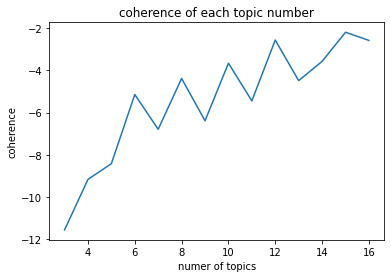

In [63]:
clean_nouns = []
for doc in set3.content:
    clean_nouns.append(remove_stopwords(doc))
noun_list_mecab = list(np.concatenate(np.array(clean_nouns)))
from collections import Counter
vocab_freq= Counter(noun_list_mecab).most_common() #갯수 많은 순으로 리스트 반환, 리스트 원소는 튜플형태
#전체단어별 index 부여 - 높은 빈도가 인덱스 1로 시작
word_to_index = {}
i=0
for (word, frequency) in vocab_freq :
    i = i + 1
    word_to_index[word] = i
vocab = list(word_to_index.keys())
vocab_freq_per_doc = []
for doc in clean_nouns:
    tmp = {}
    vocab_freq= Counter(doc).most_common() #갯수 많은 순으로 리스트 반환, 리스트 원소는 튜플형태
    for idx in range(len(vocab_freq)):
        key = word_to_index[vocab_freq[idx][0]]
        val = vocab_freq[idx][1]
        
        tmp[key]=val
    vocab_freq_per_doc.append(tmp)
dictionary = corpora.Dictionary(clean_nouns)
corpus = [dictionary.doc2bow(text) for text in clean_nouns]
X = construct_X(vocab, vocab_freq_per_doc)
n_topics = [3,4,5,6,7,8,9,10,11,12,13,14,15,16]
coherence_list = []
H_res = []
W_res = []
errors_res = []
for rank in n_topics:
    # Randomly initialize W, H with nonnegative values : uniform (1,2)
    W = np.random.uniform(1,2,(X.shape[0], rank))
    H = np.random.uniform(1,2,(rank,X.shape[1]))
    H, W, errors = NMF(iters, rank, X, W, H)
    H_res.append(H)
    W_res.append(W)
    errors_res.append(errors)
    topics = top10_per_topic(W).iloc[:,list(range(0,rank*2,2))].T.values.tolist()
    coherence_list.append(coherence(topics, corpus, dictionary))
plt.plot(n_topics, coherence_list)
plt.ylabel('coherence')
plt.xlabel('numer of topics')
plt.title('coherence of each topic number')
plt.show

In [64]:
set3_result = top10_per_topic(W_res[-2]).iloc[:,list(range(0,15*2,2))]

In [65]:
set3_result.columns=[
   '팬오션','아모레G','롯데케미칼','CJ제일제당','롯데케미칼',
    '기업은행','기아차','?','SKT','한국전력',
    '기아차','넷마블','삼성화재','SKT','LG디스플레이'
]

In [66]:
set3_result

,팬오션,아모레G,롯데케미칼,CJ제일제당,롯데케미칼,기업은행,기아차,?,SKT,한국전력,기아차,넷마블,삼성화재,SKT,LG디스플레이
0,운임,아모레,텍스,식품,편의점,대출,미국,이마트,통신,원전,임금,신작,삼성,플래닛,디스플레이
1,벌크,프리,마진,가공,레드,은행,기아차,온라인,보안,발전,통상,넷마블,화재,텔레콤,적자
2,오션,이니스,설비,제일제당,에틸렌,조달,환율,할인점,텔레콤,한전,판결,레볼루션,손해,가입자,라인
3,해운,퍼시픽,법인세,바이오,롯데케미칼,실질,쉬완,식품,캡스,요금,기아차,게임,보험,하이닉스,중소형
4,벌크선,브랜드,정제,자원,테일,위주,인수,제일제당,커머스,한국전력,금액,흥행,자보,인터넷,가동
5,규제,심화,유가,생물,미국,금리,공장,상품,자회사,이용,변론,리니지,위험,자회사,전환
6,우려,에뛰드,정유,악화,슈퍼마켓,정부,믹스,생물,가입자,석탄,기일,일본,시현,적자,대형
7,선박,중국인,전환,인수,출점,양호,신차,자원,미디어,가동,소송,게임즈,가이던스,미디어,출하량
8,수급,글로벌,고도,사료,스트림,자금,모델,바이오,번가,호기,청구,심화,삼성생명,호전,세대
9,지수,자회사,적자,이경주,절감,등급,통상,오프라인,인수,전기,노조,진출,삼성전자,통신,전자


- 많이 나온 종목 : `롯데케미칼`, `기아차`  
- 않나온 종목 : `GS`,`유한양행`,`셀트리온헬스케어`
        - 않 나온 종목들의 경우 GS의 경우는 굉장히 많음 (21개),유한양행 1, 셀트리온헬스케어 1

In [67]:
X.shape

(2825, 211)

In [68]:
set3_doc_cnt

,0,1
0,롯데케미칼,13
0,LGD,3
0,LG디스플레이,18
0,셀트리온헬스케어,1
0,유한양행,1
0,기아차,15
0,SKT,5
0,SKT2,2
0,SK텔레콤,20
0,SK텔레콤2,1


# `Set4`


## ['LG하우시스',삼성전자', '한온시스템', '현대중공업지주', 'GS건설',  '롯데지주', 'KTH','삼성SDI','SKC코오롱PI','한국가스공사',  '금호석유','우리금융지주','SK하이닉스','카카오','KTG']  
     

In [69]:
for x in stock:
    if 'KT' in x :
        print(x)

KT2
KTH
KTG
SKT
SKT2
KT


In [70]:
set4 = pd.DataFrame()
set4_doc_cnt = pd.DataFrame()
names = ['LG하우시스','삼성전자', '한온시스템', '현대중공업지주', 'GS건설',
         '롯데지주','롯데지주NR', 'KTH','삼성SDI','SKC코오롱PI','한국가스공사',
         '금호석유','우리금융지주','SK하이닉스','카카오','KTG']  
     
for name in names : 
    set4 = pd.concat([set4, data[[name == x[10:] for x in data.filename]]])
    set4_doc_cnt = pd.concat([set4_doc_cnt,pd.DataFrame(zip([name], [sum([name == x[10:] for x in data.filename])]))])

/var/folders/xb/2s8ljjjd6zg0df496bld_5bw0000gn/T/ipykernel_49425/2549085244.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  noun_list_mecab = list(np.concatenate(np.array(clean_nouns)))
100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 47.10it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

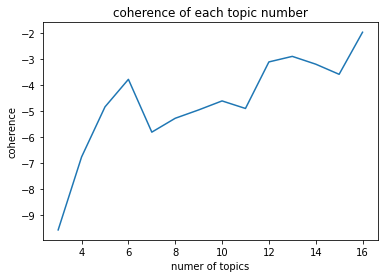

In [71]:
clean_nouns = []
for doc in set4.content:
    clean_nouns.append(remove_stopwords(doc))
noun_list_mecab = list(np.concatenate(np.array(clean_nouns)))
from collections import Counter
vocab_freq= Counter(noun_list_mecab).most_common() #갯수 많은 순으로 리스트 반환, 리스트 원소는 튜플형태
#전체단어별 index 부여 - 높은 빈도가 인덱스 1로 시작
word_to_index = {}
i=0
for (word, frequency) in vocab_freq :
    i = i + 1
    word_to_index[word] = i
vocab = list(word_to_index.keys())
vocab_freq_per_doc = []
for doc in clean_nouns:
    tmp = {}
    vocab_freq= Counter(doc).most_common() #갯수 많은 순으로 리스트 반환, 리스트 원소는 튜플형태
    for idx in range(len(vocab_freq)):
        key = word_to_index[vocab_freq[idx][0]]
        val = vocab_freq[idx][1]
        
        tmp[key]=val
    vocab_freq_per_doc.append(tmp)
dictionary = corpora.Dictionary(clean_nouns)
corpus = [dictionary.doc2bow(text) for text in clean_nouns]
X = construct_X(vocab, vocab_freq_per_doc)
n_topics = [3,4,5,6,7,8,9,10,11,12,13,14,15,16]
coherence_list = []
H_res = []
W_res = []
errors_res = []
for rank in n_topics:
    # Randomly initialize W, H with nonnegative values : uniform (1,2)
    W = np.random.uniform(1,2,(X.shape[0], rank))
    H = np.random.uniform(1,2,(rank,X.shape[1]))
    H, W, errors = NMF(iters, rank, X, W, H)
    H_res.append(H)
    W_res.append(W)
    errors_res.append(errors)
    topics = top10_per_topic(W).iloc[:,list(range(0,rank*2,2))].T.values.tolist()
    coherence_list.append(coherence(topics, corpus, dictionary))
plt.plot(n_topics, coherence_list)
plt.ylabel('coherence')
plt.xlabel('numer of topics')
plt.title('coherence of each topic number')
plt.show

In [72]:
set4_result = top10_per_topic(W_res[-2]).iloc[:,list(range(0,15*2,2))]

In [73]:
names

['LG하우시스',
 '삼성전자',
 '한온시스템',
 '현대중공업지주',
 'GS건설',
 '롯데지주',
 '롯데지주NR',
 'KTH',
 '삼성SDI',
 'SKC코오롱PI',
 '한국가스공사',
 '금호석유',
 '우리금융지주',
 'SK하이닉스',
 '카카오',
 'KTG']

In [74]:
set4_result.columns=[
    '삼성전자','삼성전자','카카오','한온시스템','SKC코오롱PI',
    '삼성전자?','한국가스공사','SK하이닉스','현대중공업지주','한국가스공사',
    'KT&G','한온시스템?','?','?','GS건설'
   ]

In [75]:
set4_result

,삼성전자,삼성전자,카카오,한온시스템,SKC코오롱PI,삼성전자?,한국가스공사,SK하이닉스,현대중공업지주,한국가스공사,KT&G,한온시스템?,?,?,GS건설
0,전지,디램,카카오,주택,필름,삼성전자,천연가스,디램,중공업,유가,담배,중공업,자동차,자동차,건설
1,삼성,설비,광고,건설,방열,출하량,가스공사,재고,글로벌,손상,수출,뱅크,부품,미국,롯데
2,전자,서버,커머스,한온,시트,반도체,유가,하이닉스,뱅크,가스,전자,한온,하우,시스,도시
3,갤럭시,메모리,게임,시스템,코오롱,스마트폰,가스,서버,로봇,보장,궐련,글로벌,시스,하우,베트남
4,재료,하이닉스,신규,유럽,스마트폰,핸드셋,규제,공급,선박,한국가스공사,동사,합병,전환,건자재,개발
5,모델,공급,상품,고무,신규,부채,프로젝트,메모리,러버,차손,내수,분할,경량,가동,세대
6,중대,삼성전자,모바일,합성,능력,메모리,한국가스공사,조절,그룹,가스공사,은행,인수,건자재,페이,부지
7,소형,스마트폰,연동,현장,가동,디램,보수,모바일,규제,정부,면세품,부채,소각,원단,부채
8,디스플레이,모바일,쇼핑,플랜트,재고,갤럭시,요금,설비,엔진,프로젝트,중소기업,시스템,인수,증설,단계
9,삼성전자,강세,성장세,환입,출하량,피쳐,손상,출하량,배당금,인식,면세,전기차,지주사,창호,계열사


In [76]:
print(names)

['LG하우시스', '삼성전자', '한온시스템', '현대중공업지주', 'GS건설', '롯데지주', '롯데지주NR', 'KTH', '삼성SDI', 'SKC코오롱PI', '한국가스공사', '금호석유', '우리금융지주', 'SK하이닉스', '카카오', 'KTG']


In [77]:
X.shape

(2642, 151)

In [78]:
set4_doc_cnt

,0,1
0,LG하우시스,10
0,삼성전자,31
0,한온시스템,11
0,현대중공업지주,9
0,GS건설,11
0,롯데지주,1
0,롯데지주NR,1
0,KTH,8
0,삼성SDI,8
0,SKC코오롱PI,7


# `Set5`

모회사가 (삼성, 현대, lg) 가 많이 중복적으로 포함된 경우  

## ['LG이노텍', '삼성증권','현대건설기계', '두산밥캣', 'SK',  '롯데지주NR', '하나금융지주', '삼성카드', 'LG화학', '현대차',  '현대중공업',SK머티리얼즈','LG생활건강','삼성물산', '삼성바이오로직스']  


In [79]:
for x in stock:
    if '삼성' in x :
        print(x)

삼성전기
삼성SDI
삼성화재
삼성카드
삼성엔지니어링
삼성생명
삼성전자
1삼성카드
삼성바이오로직스
삼성중공업
삼성물산
삼성증권


In [80]:
set5 = pd.DataFrame()
set5_doc_cnt = pd.DataFrame()
names = ['LG이노텍', '삼성증권','현대건설기계', '두산밥캣', 'SK',
         '롯데지주NR', '하나금융지주', '삼성카드','1삼성카드', 'LG화학', '현대차',
         '현대중공업','SK머티리얼즈','LG생활건강','LG생건','삼성물산', '삼성바이오로직스']  

for name in names : 
    set5 = pd.concat([set5, data[[name == x[10:] for x in data.filename]]])
    set5_doc_cnt = pd.concat([set5_doc_cnt,pd.DataFrame(zip([name], [sum([name == x[10:] for x in data.filename])]))])

/var/folders/xb/2s8ljjjd6zg0df496bld_5bw0000gn/T/ipykernel_49425/4257401171.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  noun_list_mecab = list(np.concatenate(np.array(clean_nouns)))
100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 56.16it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

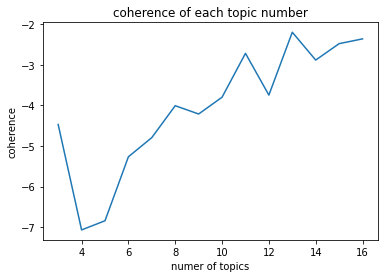

In [81]:
clean_nouns = []
for doc in set5.content:
    clean_nouns.append(remove_stopwords(doc))
noun_list_mecab = list(np.concatenate(np.array(clean_nouns)))
from collections import Counter
vocab_freq= Counter(noun_list_mecab).most_common() #갯수 많은 순으로 리스트 반환, 리스트 원소는 튜플형태
#전체단어별 index 부여 - 높은 빈도가 인덱스 1로 시작
word_to_index = {}
i=0
for (word, frequency) in vocab_freq :
    i = i + 1
    word_to_index[word] = i
vocab = list(word_to_index.keys())
vocab_freq_per_doc = []
for doc in clean_nouns:
    tmp = {}
    vocab_freq= Counter(doc).most_common() #갯수 많은 순으로 리스트 반환, 리스트 원소는 튜플형태
    for idx in range(len(vocab_freq)):
        key = word_to_index[vocab_freq[idx][0]]
        val = vocab_freq[idx][1]
        
        tmp[key]=val
    vocab_freq_per_doc.append(tmp)
dictionary = corpora.Dictionary(clean_nouns)
corpus = [dictionary.doc2bow(text) for text in clean_nouns]
X = construct_X(vocab, vocab_freq_per_doc)
n_topics = [3,4,5,6,7,8,9,10,11,12,13,14,15,16]
coherence_list = []
H_res = []
W_res = []
errors_res = []
for rank in n_topics:
    # Randomly initialize W, H with nonnegative values : uniform (1,2)
    W = np.random.uniform(1,2,(X.shape[0], rank))
    H = np.random.uniform(1,2,(rank,X.shape[1]))
    H, W, errors = NMF(iters, rank, X, W, H)
    H_res.append(H)
    W_res.append(W)
    errors_res.append(errors)
    topics = top10_per_topic(W).iloc[:,list(range(0,rank*2,2))].T.values.tolist()
    coherence_list.append(coherence(topics, corpus, dictionary))
plt.plot(n_topics, coherence_list)
plt.ylabel('coherence')
plt.xlabel('numer of topics')
plt.title('coherence of each topic number')
plt.show

In [82]:
set5_result = top10_per_topic(W_res[-2]).iloc[:,list(range(0,15*2,2))]

In [83]:
set5_result.columns = [
    'SK머티리얼즈','LG생활건강','삼성바이오로직스?,삼성물산?','현대차','삼성바이오로직스',
    '삼성카드','현대차','LG이노텍','삼성바이오로직스?','?',
    '두산밥캣','현대차','삼성바이오로직스','?','?'
]

In [84]:
set5_result

,SK머티리얼즈,LG생활건강,"삼성바이오로직스?,삼성물산?",현대차,삼성바이오로직스,삼성카드,현대차,LG이노텍,삼성바이오로직스?,?,두산밥캣,현대차,삼성바이오로직스,?,?
0,머티,화장품,바이오,현대차,바이오,신판,현대차,카메라,미국,반도체,중공업,금융,바이오,화학,삼성물산
1,리얼,생활,삼성,파업,유럽,수수료,쏘나타,북미,글로벌,호전,해양,경과,공장,석유,삼성
2,가스,브랜드,로직스,미국,피스,카드,부품,광학,메이트,매입,조선,부채,삼성,배터리,운용
3,법인,프리미엄,공장,환율,삼성,대출,신차,적자,노바,상장,두산,현대차,로직스,스트림,건설
4,자회사,건강,삼성물산,신차,로직스,금리,공장,증자,의약품,인수,건설,미국,밀러,적자,삼성전자
5,공장,호조,전지,라인업,공장,삼성카드,모델,상반기,임상,실트론,미포,중고차,피스,마진,삼성증권
6,가동,현지,회계,자동차,미국,가맹점,엔진,모델,리터,바이오,상선,리스,유럽,전자,금융
7,증설,용품,옵션,현대모비스,트루,금융,내용,유상,뇌전증,전력,밥캣,자동차,개발,악화,바이오
8,공급,음료,가동,김진우,잔트,덕분,부분,스마트폰,치료제,모듈,금융,무형,미국,디스플레이,삼성생명
9,인도,채널,피스,재고,밀러,경상,플랫,이노,바이오팜,이노베이션,손실,기아차,동사,전환,계열사


In [85]:
set5_doc_cnt

,0,1
0,LG이노텍,8
0,삼성증권,9
0,현대건설기계,5
0,두산밥캣,4
0,SK,10
0,롯데지주NR,1
0,하나금융지주,8
0,삼성카드,12
0,1삼성카드,1
0,LG화학,12


In [86]:
X.shape

(2605, 153)

# `Set6`

## ['삼성전기', '롯데지주NR','두산중공업', '현대제철', '현대글로비스',  '삼성중공업','삼성엔지니어링']

In [87]:
for x in stock:
    if '삼성' in x :
        print(x)

삼성전기
삼성SDI
삼성화재
삼성카드
삼성엔지니어링
삼성생명
삼성전자
1삼성카드
삼성바이오로직스
삼성중공업
삼성물산
삼성증권


In [88]:
set6 = pd.DataFrame()
set6_doc_cnt = pd.DataFrame()
names = [
    '삼성전기','롯데지주','롯데지주NR','두산중공업','현대제철',
    '현대글로비스','삼성중공업','삼성엔지니어링'
]  

for name in names : 
    set6 = pd.concat([set6, data[[name == x[10:] for x in data.filename]]])
    set6_doc_cnt = pd.concat([set6_doc_cnt,pd.DataFrame(zip([name], [sum([name == x[10:] for x in data.filename])]))])

/var/folders/xb/2s8ljjjd6zg0df496bld_5bw0000gn/T/ipykernel_49425/173360173.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  noun_list_mecab = list(np.concatenate(np.array(clean_nouns)))
100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 98.41it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

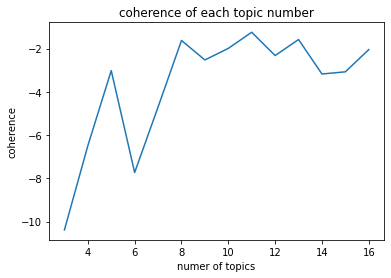

In [89]:
clean_nouns = []
for doc in set6.content:
    clean_nouns.append(remove_stopwords(doc))
noun_list_mecab = list(np.concatenate(np.array(clean_nouns)))
from collections import Counter
vocab_freq= Counter(noun_list_mecab).most_common() #갯수 많은 순으로 리스트 반환, 리스트 원소는 튜플형태
#전체단어별 index 부여 - 높은 빈도가 인덱스 1로 시작
word_to_index = {}
i=0
for (word, frequency) in vocab_freq :
    i = i + 1
    word_to_index[word] = i
vocab = list(word_to_index.keys())
vocab_freq_per_doc = []
for doc in clean_nouns:
    tmp = {}
    vocab_freq= Counter(doc).most_common() #갯수 많은 순으로 리스트 반환, 리스트 원소는 튜플형태
    for idx in range(len(vocab_freq)):
        key = word_to_index[vocab_freq[idx][0]]
        val = vocab_freq[idx][1]
        
        tmp[key]=val
    vocab_freq_per_doc.append(tmp)
dictionary = corpora.Dictionary(clean_nouns)
corpus = [dictionary.doc2bow(text) for text in clean_nouns]
X = construct_X(vocab, vocab_freq_per_doc)
n_topics = [3,4,5,6,7,8,9,10,11,12,13,14,15,16]
coherence_list = []
H_res = []
W_res = []
errors_res = []
for rank in n_topics:
    # Randomly initialize W, H with nonnegative values : uniform (1,2)
    W = np.random.uniform(1,2,(X.shape[0], rank))
    H = np.random.uniform(1,2,(rank,X.shape[1]))
    H, W, errors = NMF(iters, rank, X, W, H)
    H_res.append(H)
    W_res.append(W)
    errors_res.append(errors)
    topics = top10_per_topic(W).iloc[:,list(range(0,rank*2,2))].T.values.tolist()
    coherence_list.append(coherence(topics, corpus, dictionary))
plt.plot(n_topics, coherence_list)
plt.ylabel('coherence')
plt.xlabel('numer of topics')
plt.title('coherence of each topic number')
plt.show

In [90]:
set6_result = top10_per_topic(W_res[-2]).iloc[:,list(range(0,7*2,2))]

In [91]:
names

['삼성전기', '롯데지주', '롯데지주NR', '두산중공업', '현대제철', '현대글로비스', '삼성중공업', '삼성엔지니어링']

In [92]:
set6_result.columns = ['삼성전기?엔지니어링?','삼성중공업?엔지니어링?','현대글로비스','현대글로비스','삼성전기','삼성중공업?두산중공업?',
                      '현대제철']

In [93]:
set6_result

,삼성전기?엔지니어링?,삼성중공업?엔지니어링?,현대글로비스,현대글로비스,삼성전기,삼성중공업?두산중공업?,현대제철
0,카메라,공사,로비스,비스,삼성전기,중공업,자동차
1,듀얼,청구,물류,합병,기판,삼성,동력
2,삼성엔지니어링,삼성,비스,분할,공급,해양,현대제철
3,삼성전기,중공업,그룹,모비스,부품,인도,롯데
4,프로젝트,증자,현대차,그룹,모듈,드릴,강판
5,업그레이드,삼성엔지니어링,규제,법인,카메라,상선,특수강
6,스펙,인도,물량,본업,삼성전자,리스크,철강
7,플랜트,유상,일감,일감,스마트폰,발주,자체
8,모듈,유입,글로벌,일가,전장용,리그,가동
9,공급,선수금,판재,오너,사향,조선,순천


In [94]:
X.shape

(1717, 88)

In [95]:
set6_doc_cnt

,0,1
0,삼성전기,17
0,롯데지주,1
0,롯데지주NR,1
0,두산중공업,6
0,현대제철,10
0,현대글로비스,22
0,삼성중공업,11
0,삼성엔지니어링,20


# PLOT

In [96]:
%matplotlib inline
from matplotlib import rc
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

In [97]:
set1_doc_cnt.columns = ['stock','cnt']
set1_doc_cnt = set1_doc_cnt.reset_index()[['stock','cnt']]
set1_doc_cnt

,stock,cnt
0,현대모비스,14
1,KT,30
2,KT2,6
3,엔씨소프트,28
4,롯데하이마트,10
5,S-Oil,8
6,셀트리온,1
7,한국항공우주,11
8,KB금융,10
9,LG전자,12


In [98]:
set1_doc_cnt = set1_doc_cnt.drop([1,2,13,14])
tmp = pd.DataFrame([['KT',36],['아모레퍼시픽',19]], columns = ['stock','cnt'])
set1_doc_cnt=pd.concat([set1_doc_cnt,tmp],axis=0)

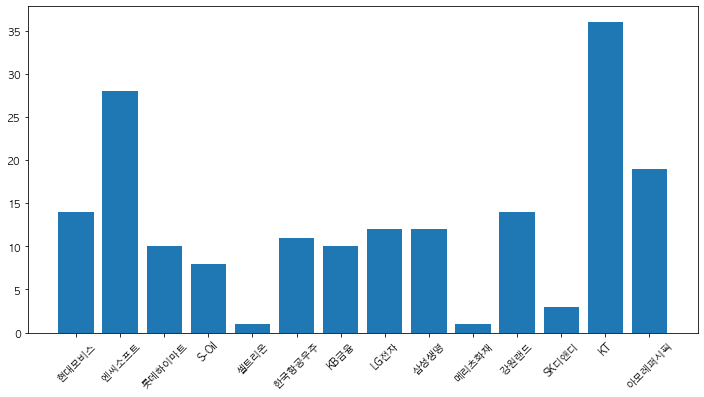

In [99]:
plt.figure(figsize=(12,6))
plt.bar(set1_doc_cnt.stock,set1_doc_cnt.cnt)
plt.xticks(rotation = 45)
plt.show()

In [100]:
set1_doc_cnt.sort_values(by='cnt',ascending=False,ignore_index=True)

,stock,cnt
0,KT,36
1,엔씨소프트,28
2,아모레퍼시픽,19
3,현대모비스,14
4,강원랜드,14
5,LG전자,12
6,삼성생명,12
7,한국항공우주,11
8,롯데하이마트,10
9,KB금융,10


In [101]:
set2_doc_cnt.columns = ['stock','cnt']
set2_doc_cnt = set2_doc_cnt.reset_index()[['stock','cnt']]
set2_doc_cnt

,stock,cnt
0,현대건설,9
1,넷마블,5
2,넷마블게임즈,5
3,LGU,5
4,LG유플러스,23
5,LG유플러스2,4
6,고려아연,14
7,SK이노베이션,17
8,GS홈쇼핑,6
9,오리온,26


In [102]:
set2_doc_cnt = set2_doc_cnt.drop([1,2,3,4,5])
tmp = pd.DataFrame([['넷마블',10],['LG유플러스',32]], columns = ['stock','cnt'])
set2_doc_cnt=pd.concat([set2_doc_cnt,tmp],axis=0)

In [103]:
set2_doc_cnt.sort_values(by='cnt',ascending=False,ignore_index=True)

,stock,cnt
0,LG유플러스,32
1,오리온,26
2,대한항공,22
3,SK이노베이션,17
4,고려아연,14
5,신한지주,12
6,코웨이,12
7,호텔신라,12
8,넷마블,10
9,현대건설,9


In [104]:
set3_doc_cnt.columns = ['stock','cnt']
set3_doc_cnt = set3_doc_cnt.reset_index()[['stock','cnt']]
set3_doc_cnt

,stock,cnt
0,롯데케미칼,13
1,LGD,3
2,LG디스플레이,18
3,셀트리온헬스케어,1
4,유한양행,1
5,기아차,15
6,SKT,5
7,SKT2,2
8,SK텔레콤,20
9,SK텔레콤2,1


In [105]:
set3_doc_cnt = set3_doc_cnt.drop([1,2,6,7,8,9,11,12,14,15,18,19])
tmp = pd.DataFrame([['LG디스플레이',21],['SK텔레콤',28],['CJ제일제당',27],['넷마블',10],['GS',21]], columns = ['stock','cnt'])
set3_doc_cnt=pd.concat([set3_doc_cnt,tmp],axis=0)

In [106]:
set3_doc_cnt.sort_values(by='cnt',ascending=False,ignore_index=True)

,stock,cnt
0,SK텔레콤,28
1,CJ제일제당,27
2,한국전력,22
3,LG디스플레이,21
4,GS,21
5,이마트,16
6,기아차,15
7,롯데케미칼,13
8,삼성화재,11
9,기업은행,11


In [107]:
set4_doc_cnt.columns = ['stock','cnt']
set4_doc_cnt = set4_doc_cnt.reset_index()[['stock','cnt']]
set4_doc_cnt

,stock,cnt
0,LG하우시스,10
1,삼성전자,31
2,한온시스템,11
3,현대중공업지주,9
4,GS건설,11
5,롯데지주,1
6,롯데지주NR,1
7,KTH,8
8,삼성SDI,8
9,SKC코오롱PI,7


In [108]:
set4_doc_cnt = set4_doc_cnt.drop([5,6])
tmp = pd.DataFrame([['롯데지주',2]], columns = ['stock','cnt'])
set4_doc_cnt=pd.concat([set4_doc_cnt,tmp],axis=0)

In [109]:
set4_doc_cnt.sort_values(by='cnt',ascending=False,ignore_index=True)

,stock,cnt
0,삼성전자,31
1,SK하이닉스,19
2,한국가스공사,14
3,한온시스템,11
4,GS건설,11
5,LG하우시스,10
6,현대중공업지주,9
7,카카오,9
8,KTH,8
9,삼성SDI,8


In [110]:
set5_doc_cnt.columns = ['stock','cnt']
set5_doc_cnt = set5_doc_cnt.reset_index()[['stock','cnt']]
set5_doc_cnt

,stock,cnt
0,LG이노텍,8
1,삼성증권,9
2,현대건설기계,5
3,두산밥캣,4
4,SK,10
5,롯데지주NR,1
6,하나금융지주,8
7,삼성카드,12
8,1삼성카드,1
9,LG화학,12


In [111]:
set5_doc_cnt = set5_doc_cnt.drop([5,7,8,13,14])
tmp = pd.DataFrame([['롯데지주',1],['삼성카드',13],['LG생활건강',12]], columns = ['stock','cnt'])
set5_doc_cnt=pd.concat([set5_doc_cnt,tmp],axis=0)
set5_doc_cnt.sort_values(by='cnt',ascending=False,ignore_index=True)

,stock,cnt
0,현대차,19
1,삼성바이오로직스,19
2,삼성물산,13
3,삼성카드,13
4,LG화학,12
5,LG생활건강,12
6,SK,10
7,현대중공업,10
8,SK머티리얼즈,10
9,삼성증권,9


In [112]:
set6_doc_cnt.columns = ['stock','cnt']
set6_doc_cnt = set6_doc_cnt.reset_index()[['stock','cnt']]
set6_doc_cnt

,stock,cnt
0,삼성전기,17
1,롯데지주,1
2,롯데지주NR,1
3,두산중공업,6
4,현대제철,10
5,현대글로비스,22
6,삼성중공업,11
7,삼성엔지니어링,20


In [113]:
set6_doc_cnt = set6_doc_cnt.drop([1,2])
tmp = pd.DataFrame([['롯데지주',2]], columns = ['stock','cnt'])
set6_doc_cnt=pd.concat([set6_doc_cnt,tmp],axis=0)
set6_doc_cnt.sort_values(by='cnt',ascending=False,ignore_index=True)

,stock,cnt
0,현대글로비스,22
1,삼성엔지니어링,20
2,삼성전기,17
3,삼성중공업,11
4,현대제철,10
5,두산중공업,6
6,롯데지주,2


# Wordcloud

In [116]:
from wordcloud import WordCloud

In [133]:
palettes = ['spring', 'summer', 'seismic','PuBu']

In [205]:
wordcloud = WordCloud(
    font_path = '/Users/sera/company/BMJUA_otf.otf', 
    background_color='white',                            
    colormap = palettes[3],                               
    width = 400,
    height = 400,
    min_font_size=50,
    max_font_size=100
)


In [199]:
set4_result

,삼성전자,삼성전자,카카오,한온시스템,SKC코오롱PI,삼성전자?,한국가스공사,SK하이닉스,현대중공업지주,한국가스공사,KT&G,한온시스템?,?,?,GS건설
0,전지,디램,카카오,주택,필름,삼성전자,천연가스,디램,중공업,유가,담배,중공업,자동차,자동차,건설
1,삼성,설비,광고,건설,방열,출하량,가스공사,재고,글로벌,손상,수출,뱅크,부품,미국,롯데
2,전자,서버,커머스,한온,시트,반도체,유가,하이닉스,뱅크,가스,전자,한온,하우,시스,도시
3,갤럭시,메모리,게임,시스템,코오롱,스마트폰,가스,서버,로봇,보장,궐련,글로벌,시스,하우,베트남
4,재료,하이닉스,신규,유럽,스마트폰,핸드셋,규제,공급,선박,한국가스공사,동사,합병,전환,건자재,개발
5,모델,공급,상품,고무,신규,부채,프로젝트,메모리,러버,차손,내수,분할,경량,가동,세대
6,중대,삼성전자,모바일,합성,능력,메모리,한국가스공사,조절,그룹,가스공사,은행,인수,건자재,페이,부지
7,소형,스마트폰,연동,현장,가동,디램,보수,모바일,규제,정부,면세품,부채,소각,원단,부채
8,디스플레이,모바일,쇼핑,플랜트,재고,갤럭시,요금,설비,엔진,프로젝트,중소기업,시스템,인수,증설,단계
9,삼성전자,강세,성장세,환입,출하량,피쳐,손상,출하량,배당금,인식,면세,전기차,지주사,창호,계열사


In [200]:
wordcloud_words = wordcloud.generate_from_frequencies(Counter(set1_result.LG전자))

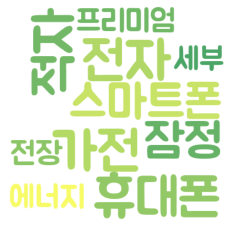

In [201]:
plt.imshow(wordcloud_words)
plt.axis('off')
plt.show()

In [206]:
wordcloud_words = wordcloud.generate_from_frequencies(Counter(set4_result.삼성전자.iloc[:,1]))

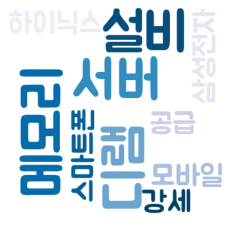

In [207]:
plt.imshow(wordcloud_words)
plt.axis('off')
plt.show()

In [220]:
set2_result

,SK이노베이션,신한지주,호텔신라,현대건설,고려아연,오리온,대한항공,코웨이,넷마블,호텔신라,한미약품,LG유플러스,오리온,DB손해보험,NH투자증권
0,마진,대출,공항,건설,아연,베트남,항공,렌탈,신작,공항,한미,가입자,오리온,손해,운용
1,쇼핑,신한,호텔신라,프로젝트,제련,오리온,여객,정수기,넷마블,호텔,약품,플러스,베트남,보험,수수료
2,유가,은행,호텔,현장,수수료,춘절,대한항공,계정수,레볼루션,호텔신라,임상,통신,러시아,요율,금융
3,이노베이션,카드,홍콩,업종,정광,이슈,국제선,코웨이,게임,레저,파이프라인,호전,춘절,자보,수지
4,정제,그룹,시내,회계,금속,재고,유가,계정,흥행,신라,기술,인터넷,제과,위험,양호
5,정유,경상,레저,주택,련사,제과,화물,청정기,리니지,홍콩,데이터,마케팅,스포츠토토,은행,트레이딩
6,재고,덕분,제주,현대건설,공급,동월,운임,말레이시아,게임즈,제주,치료제,호조,외형,타이어,인수
7,급고,금리,운영,공사,출하량,유통,노선,금년,일본,스테이,마일스톤,요금,이경주,금리,헤지
8,모바일,원화,신라,감리,비철,가수요,공급,호조,심화,부채,사이언스,절감,이화경,가이던스,펀드
9,화학,양호,서울,가이던스,생산량,사드,항공사,정체,모바일,시내,합산,단말기,정도,글로벌,농협


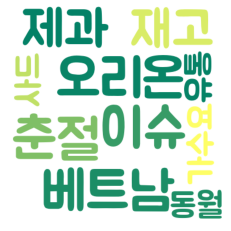

In [225]:
wordcloud = WordCloud(
    font_path = '/Users/sera/company/BMJUA_otf.otf', 
    background_color='white',                            
    colormap = palettes[1],                               
    width = 400,
    height = 400,
    min_font_size=50,
    max_font_size=100
)
wordcloud_words = wordcloud.generate_from_frequencies(Counter(set2_result.오리온.iloc[:,0]))
plt.imshow(wordcloud_words)
plt.axis('off')
plt.show()

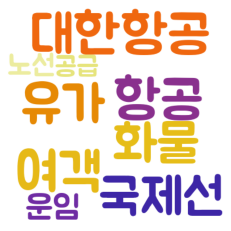

In [230]:
wordcloud = WordCloud(
    font_path = '/Users/sera/company/BMJUA_otf.otf', 
    background_color='white',                            
    colormap = 'CMRmap_r',                               
    width = 400,
    height = 400,
    min_font_size=50,
    max_font_size=100
)
wordcloud_words = wordcloud.generate_from_frequencies(Counter(set2_result.대한항공))
plt.imshow(wordcloud_words)
plt.axis('off')
plt.show()

In [228]:
# Accent, Accent_r, Blues, Blues_r,
# BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, 
# CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens,
# Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, 
# PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r,
# PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, 
# Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r,
# Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, 
# YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r,
# autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, 
# cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, 
# flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, 
# gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg,
# gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, 
# inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, 
# pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral,
# spectral_r, spring, spring_r, summer, summer_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

In [292]:
set5_result

,SK머티리얼즈,LG생활건강,"삼성바이오로직스?,삼성물산?",현대차,삼성바이오로직스,삼성카드,현대차,LG이노텍,삼성바이오로직스?,?,두산밥캣,현대차,삼성바이오로직스,?,?
0,머티,화장품,바이오,현대차,바이오,신판,현대차,카메라,미국,반도체,중공업,금융,바이오,화학,삼성물산
1,리얼,생활,삼성,파업,유럽,수수료,쏘나타,북미,글로벌,호전,해양,경과,공장,석유,삼성
2,가스,브랜드,로직스,미국,피스,카드,부품,광학,메이트,매입,조선,부채,삼성,배터리,운용
3,법인,프리미엄,공장,환율,삼성,대출,신차,적자,노바,상장,두산,현대차,로직스,스트림,건설
4,자회사,건강,삼성물산,신차,로직스,금리,공장,증자,의약품,인수,건설,미국,밀러,적자,삼성전자
5,공장,호조,전지,라인업,공장,삼성카드,모델,상반기,임상,실트론,미포,중고차,피스,마진,삼성증권
6,가동,현지,회계,자동차,미국,가맹점,엔진,모델,리터,바이오,상선,리스,유럽,전자,금융
7,증설,용품,옵션,현대모비스,트루,금융,내용,유상,뇌전증,전력,밥캣,자동차,개발,악화,바이오
8,공급,음료,가동,김진우,잔트,덕분,부분,스마트폰,치료제,모듈,금융,무형,미국,디스플레이,삼성생명
9,인도,채널,피스,재고,밀러,경상,플랫,이노,바이오팜,이노베이션,손실,기아차,동사,전환,계열사


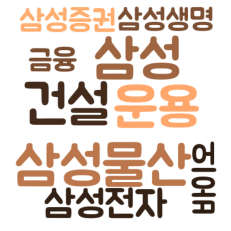

In [300]:
wordcloud = WordCloud(
    font_path = '/Users/sera/company/BMJUA_otf.otf', 
    background_color='white',                            
    colormap = 'copper',                               
    width = 400,
    height = 400,
    min_font_size=50,
    max_font_size=100
)
wordcloud_words = wordcloud.generate_from_frequencies(Counter(set5_result.iloc[:,-1]))
plt.imshow(wordcloud_words)
plt.axis('off')
plt.show()

In [219]:
data[list(map(lambda x: '삼성전자' in x, data.filename ))].content[11]

' 삼성전자 하 회 부 합 상 회 주 영업이익의 컨센서스 대비를 의미 년만의 실적 추정치 하향 DP부문 실적추정치 하향 반영해 년 전사 영업이익 으로 하향 스마트폰 수요부진으로 낸드가격도 하락 전망 예상 상회한 년 배당액 및 액면분할 등으로 밸류에이션 상승기대감은 유효 Facts 년 배당 당초 계획보다 증가 년 기말 배당은 보통주 기준 주당 원 우선주 포함 연간 배당총액은 으로 지난 월에 발표한 을 상회했다 년 FCF의 를 지급한 것으로 적극적인 주주환원 정책을 확인할 수 있다 배당확대 외에 액면분할을 결정했다 주주가치의 펀더멘탈한 변화는 없지만 주당 가격하락으로 유동성 및 개인투자자들의 투자 증대 등을 기대할 수 있다 년 년의 매 해 배당총액은 으로 변동이 없고 현재 주가기준 배당수익률은 이지만 년 이후 추가적인 주주환원이 발생할 가능성이 높아 실질적인 주주환원 규모 확대가 지속될 것이다 주주환원 정책확대와 액면분할 등으로 주가의 밸류에이션 수준이 높아질 것으로 예상한다 Pros amp cons 모바일수요 둔화로 DP부문 이익추정치 큰 폭 감소 플렉서블 OLED패널 주요고객의 예상보다 부진한 스마트폰 수요를 반영해 년 상반기 DP부문의 실적 추정치를 크게 하향했다 하반기 신모델 출시로 인한 회 복이 예상되지만 년 DP부문의 연간 영업이익은 으로 당초대비 하향됐다 디스플레이 패널을 포함한 부품가격 상승을 반영한 스마트폰 가격상승 이 수요부진의 직접적인 원인이라고 보면 삼성전자 스마트폰사업 수익성 압박 요 인도 크다고 볼 수 있다 반도체부문의 경우 상대적으로 영향이 덜하다고 할 수 있 지만 낸드수요에 영향을 줘 낸드수급 약화와 가격하락의 원인이 되고 있다 스마 트폰산업의 수요부진을 반영해 삼성전자의 년 영업이익을 으로 당 초 예상대비 하향했다 년만에 첫 실적추정치 하향이다 Action 단기 모멘텀 약화 전망 하지만 밸류에이션 상승 기대 실적 추정치가 하향을 반영해 목표주가는 원으로 기존대비 하향한 다 스마트폰 수요부진의 영향이 어느 정도 확인될 때까지 주가의 단

In [253]:
cnt = pd.concat([set1_doc_cnt.sort_values(by='cnt',ascending=False,ignore_index=True)\
           ,set2_doc_cnt.sort_values(by='cnt',ascending=False,ignore_index=True)\
          ,set3_doc_cnt.sort_values(by='cnt',ascending=False,ignore_index=True)\
          ,set4_doc_cnt.sort_values(by='cnt',ascending=False,ignore_index=True)\
          ,set5_doc_cnt.sort_values(by='cnt',ascending=False,ignore_index=True)\
          ,set6_doc_cnt.sort_values(by='cnt',ascending=False,ignore_index=True)]
          ,ignore_index=True,axis=1)

In [254]:
cnt

,0,1,2,3,4,5,6,7,8,9,10,11
0,KT,36.0,LG유플러스,32,SK텔레콤,28,삼성전자,31,현대차,19,현대글로비스,22.0
1,엔씨소프트,28.0,오리온,26,CJ제일제당,27,SK하이닉스,19,삼성바이오로직스,19,삼성엔지니어링,20.0
2,아모레퍼시픽,19.0,대한항공,22,한국전력,22,한국가스공사,14,삼성물산,13,삼성전기,17.0
3,현대모비스,14.0,SK이노베이션,17,LG디스플레이,21,한온시스템,11,삼성카드,13,삼성중공업,11.0
4,강원랜드,14.0,고려아연,14,GS,21,GS건설,11,LG화학,12,현대제철,10.0
5,LG전자,12.0,신한지주,12,이마트,16,LG하우시스,10,LG생활건강,12,두산중공업,6.0
6,삼성생명,12.0,코웨이,12,기아차,15,현대중공업지주,9,SK,10,롯데지주,2.0
7,한국항공우주,11.0,호텔신라,12,롯데케미칼,13,카카오,9,현대중공업,10,NaN,NaN
8,롯데하이마트,10.0,넷마블,10,삼성화재,11,KTH,8,SK머티리얼즈,10,NaN,NaN
9,KB금융,10.0,현대건설,9,기업은행,11,삼성SDI,8,삼성증권,9,NaN,NaN
